# **Digital Signal and Image Management - E01**<br/>
**Master's Degree in Data Science (A.Y. 2022/2023)**<br/>
**University of Milano - Bicocca**<br/>

prof. Simone Bianco, dr. Marco Buzzelli

In [491]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd

# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# File management
from google.colab import drive
import tarfile
from shutil import copyfile

## Data import

**Note:**
* Before continuing, you must import this file into your own Google Drive:<br/>https://drive.google.com/file/d/1w9l6WnU-oQ-8IsY1NSRcWNulqcQ5DHFK/view?usp=sharing<br/>(Top-right corner -> Add shortcut to Drive -> My Drive -> Add shortcut here)
* If the link no longer works, you can retrieve the original dataset from:<br/>https://github.com/Jakobovski/free-spoken-digit-dataset

In [492]:
# Link Google Drive account, transfer dataset, and extract files
drive.mount('/content/gdrive')
copyfile('gdrive/My Drive/recordings.tar', 'recordings.tar')
tar = tarfile.open('recordings.tar')
tar.extractall()
tar.close()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


https://colab.research.google.com/<br/>
https://colab.research.google.com/notebooks/io.ipynb

**Note:**
* We store a compressed dataset on Google Drive, import it on the colab machine, and extract it.
* This is significantly faster than:
 * uploading the dataset everytime we open colab, or
 * importing/referencing a folder (individual files) from Google Drive.

In [493]:
# Import file
sound_rate, sound_data = wav.read('recordings/0_jackson_0.wav')
# Play the signal
ipd.Audio(sound_data, rate=sound_rate)

In [494]:
# Shape of the audio array: 5148 values, one dimension
sound_data.shape

(5148,)

In [495]:
# Sampling rate: 8000 samples per second
sound_rate

8000

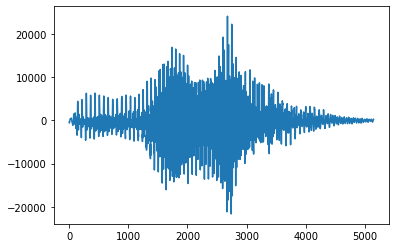

In [496]:
plt.plot(sound_data)

https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html<br/>
https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#IPython.display.Audio

**Note**:
* When we import an audio file, we obtain an extra piece of information about the **sampling rate** that was used for its creation: how many audio samples per second.
* We must reuse this information as **playback rate**: telling an audio player how many samples per second should be played.

## Data loader

In [497]:
# Placecholder for feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Classes
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

**Note:**
1. Load the data from disk
2. Extract the class specified in the filename
3. Split audio tracks into training set and test set
4. Normalize the data using training set statistics

## Features

**Note:**

``scikit-learn`` classifiers cannot directly use a scalar feature.<br/>
They can, however, use an equivalent monodimensional vector with size = 1.

The effect of using ``keepdims=True`` during the feature computation is shown here:

In [498]:
# Create sample data and corresponding feature
dummy_data = np.random.rand(100)
feats_scalar = np.std(dummy_data)
feats_vector = np.std(dummy_data, keepdims=True)

In [499]:
# Scalar feature
print(feats_scalar)
print(feats_scalar.shape)

0.28313730423294625
()


In [500]:
# Vector feature
print(feats_vector)
print(feats_vector.shape)

[0.2831373]
(1,)


### Energy

$
E(x) = \sum_i x_i^2
$

In [501]:
def energy(input):
    return np.sum((input*1.0)**2, keepdims=True)

**Note:**
* Energy is defined as the sum of squared samples.
* It can be imagined as a representing the "volume" of the audio.
* The squared exponent serves two purposes:
  1. Avoids positive and negative samples cancelling each other.
  2. Gives more weight to samples with (absolute) higher value.

In [502]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=energy)
print('Numer of training examples: {}'.format(len(X_train)))
print('Dimensionality of the training features: {}'.format(X_train[0].shape))

Numer of training examples: 1350
Dimensionality of the training features: (1,)


In [503]:
# Support Vector Machine (SVM) initialization
clf = SVC(kernel='rbf', class_weight='balanced')

In [504]:
# SVM training
clf = clf.fit(X_train, y_train)

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html<br/>
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.fit

**Note:**
* We are using a Support Vector Machine with kernel based on the Radial Basis Function (RBF)
* Default parameters will be later replaced with a search for optimal ones

In [505]:
# SVM inference
y_pred = clf.predict(X_test)

In [506]:
# Classification report
print('Classification report:')
print(classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.50      0.06      0.11        17
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        15
           3       0.17      0.58      0.26        19
           4       0.12      0.27      0.17        11
           5       0.10      0.14      0.12        14
           6       0.40      0.29      0.33        14
           7       0.14      0.16      0.15        19
           8       0.00      0.00      0.00        17
           9       0.00      0.00      0.00        14

    accuracy                           0.16       150
   macro avg       0.14      0.15      0.11       150
weighted avg       0.15      0.16      0.12       150



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.predict<br/>
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html<br/>

**Note:**
* Differently from other frameworks, in `sklearn` we do not have an `evaluate` function that performs inference and compares the result to a ground truth.
* We only have the `predict` function, which only performs inference.
* We can obtain a detailed test report using `skelarn`'s `classification_report`.
  * Accuracy: how many samples were correctly classified on the whole test set.
  * Macro avg: accuracy is computed for each class independently, then all (10) accuracy values are averaged.
    * Macro avg is important when the classes are unbalanced.
* We notice how some classes have all statistics set to 0: i.e. they are never predicted.<br/>Regardless of the accuracy, this behavior is not acceptable.

In [507]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
print(cm)

Confusion matrix:
[[ 1  0  1  9  0  2  2  2  0  0]
 [ 0  0  0  6  4  0  0  0  0  0]
 [ 0  0  0  6  1  5  0  3  0  0]
 [ 0  0  1 11  4  2  0  1  0  0]
 [ 1  0  2  1  3  0  2  2  0  0]
 [ 0  0  1  5  3  2  1  2  0  0]
 [ 0  0  0  8  0  0  4  2  0  0]
 [ 0  0  0  9  2  5  0  3  0  0]
 [ 0  0  0  7  3  4  1  2  0  0]
 [ 0  0  1  3  5  0  0  5  0  0]]


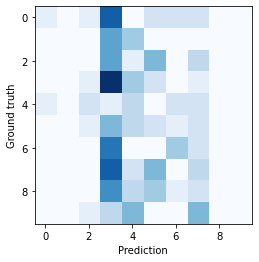

In [508]:
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Prediction');
plt.ylabel('Ground truth');

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

**Note:**
* Further details can be inferred by using a confusion matrix (either in textual or visual form).
  * Rows: ground truth
  * Columns: predictions
* We notice how most of the predictions are for the class '3'. This is also not a good behavior.

### Duration

In [509]:
def duration(input):
    return np.array(input.shape)

**Note:**
* Assuming that all audio samples have the same sample rate, the duration can be simply expressed as the number of elements in each audio file.

In [510]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=duration)

In [511]:
# SVM initialization and training
clf = SVC(kernel='rbf', class_weight='balanced')
clf = clf.fit(X_train, y_train)

In [512]:
# SVM test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.32      0.41      0.36        17
           1       0.22      0.40      0.29        10
           2       0.00      0.00      0.00        15
           3       0.38      0.26      0.31        19
           4       0.38      0.27      0.32        11
           5       0.00      0.00      0.00        14
           6       0.67      0.14      0.24        14
           7       0.33      0.05      0.09        19
           8       0.26      0.71      0.37        17
           9       0.06      0.14      0.08        14

    accuracy                           0.24       150
   macro avg       0.26      0.24      0.21       150
weighted avg       0.27      0.24      0.21       150



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix:


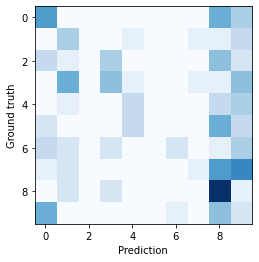

In [513]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Prediction');
plt.ylabel('Ground truth');

**Note:**
* Changing feature improved the accuracy, but we still have the two fundamental problems:
  * Classes that are never predicted.
  * Preference for predicting one specific class.

## Features combo with normalization

In [514]:
def combo(input):
    return np.concatenate((energy(input),duration(input)))

**Note:**
* We will now try combining the two features that we have defined.
* When combining multiple features (or, in general, dealing with multi-dimensional features) it is advisable to normalize the data:
  * We have a $N\times M$ matrix, where $N$ is the number of samples, and $M$ is the dimensionality of the (combined) features.
  * We choose z-score standardization for each **column** as our normalization:
    * Every sub-feature will have average 0 and standard deviation 1 across all training examples.
    * The same statistics that ensure this property on the training set will be used to modify also the test set.
  * If we do not normalize the data, we risk that one sub feature is neglected by the classifier only because it happens to have generally smaller values.
    * (Try disabling normalization!)

In [515]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo, normalize=True)
print('Numer of training examples: {}'.format(len(X_train)))
print('Dimensionality of the training features: {}'.format(X_train[0].shape))

Numer of training examples: 1350
Dimensionality of the training features: (2,)


In [516]:
# SVM initialization and training
clf = SVC(kernel='rbf', class_weight='balanced')
clf = clf.fit(X_train, y_train)

In [517]:
# SVM test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.24      0.35        17
           1       0.11      0.10      0.11        10
           2       0.00      0.00      0.00        15
           3       0.39      0.63      0.48        19
           4       0.46      0.55      0.50        11
           5       0.17      0.14      0.15        14
           6       0.50      0.14      0.22        14
           7       0.38      0.16      0.22        19
           8       0.09      0.12      0.10        17
           9       0.26      0.71      0.38        14

    accuracy                           0.28       150
   macro avg       0.30      0.28      0.25       150
weighted avg       0.31      0.28      0.25       150



Confusion matrix:


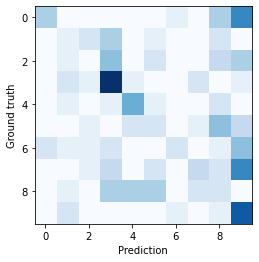

In [518]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Prediction');
plt.ylabel('Ground truth');

**Note:**
* The performance of the classifier is further improved.
* The two main problems have been mitigated.
* Still, 25% accuracy on a 10-class problem is not ideal.

## Hyperparameter optimization

In [519]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo, normalize=True)

In [520]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 4.215s


https://scikit-learn.org/stable/modules/grid_search.html#grid-search<br/>
https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html<br/>
https://cs.stanford.edu/people/karpathy/svmjs/demo/

**Note:**
* As previously mentioned, the RBF kernel supports two parameters, for which we have so far used default values.
* We can enumerate each parameter ('C' and 'gamma'), provide a range of possible values for each, and run a grid search.
* The grid search internally uses cross validation, splitting the training set into `cv` folds in order to produce a fair output performance.
* When the best combination of parameter is found using this split, it is finally used to retrain an SVM on the whole training set.

In [521]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 1000
 gamma: 0.1


In [522]:
# SVM test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.47      0.48        17
           1       0.15      0.20      0.17        10
           2       0.00      0.00      0.00        15
           3       0.38      0.53      0.44        19
           4       0.45      0.45      0.45        11
           5       0.19      0.21      0.20        14
           6       0.47      0.50      0.48        14
           7       0.36      0.21      0.27        19
           8       0.14      0.12      0.13        17
           9       0.36      0.57      0.44        14

    accuracy                           0.33       150
   macro avg       0.30      0.33      0.31       150
weighted avg       0.31      0.33      0.31       150



Confusion matrix:


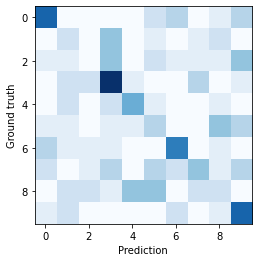

In [523]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Prediction');
plt.ylabel('Ground truth');

**Note:**
* The combination of multiple features, properly normalized, and the selection of optimal hyperparameters, lead to a further increase in the model's performance.

## Assignment: Zero-Crossing Rate

**Zero-Crossing Rate**:
count how many times the signal goes from positive to negative, and from negative to positive.

Possible approach:

1. Shift the signal by one unit
2. Compare point-by-point the sign (``np.sign()``) of the original signal and of the shifted signal
3. Accumulate the instances of sign change

### Simple ZCR
In questa sezione alleniamo una SVM utilizzando solamente la feature ZCR.

In [524]:
def zcr(input):
    shifted_signal = np.roll(input, -1)   # shift del segnale di una posizione a sinistra

    shifted_signal_sign = np.sign(shifted_signal[:-1])    # estraggo il segno dai due vettori escludendo l'ultima posizione
    input_sign = np.sign(input[:-1])

    mult_sign = input_sign * shifted_signal_sign    # moltiplico i due vettori. Ci sarà -1 se di segni discordi. 

    zc = 0
    for i in range (mult_sign.size):
      if mult_sign[i] < 0:    # conto le volte che il segnale cambia da positivo a negativo; se c'è 0 non lo considero
        zc = zc + 1                                    

    output = [zc]
    return output

La versione seguente è una alternativa utilizzata solo nelle prove:
conta il passaggio dallo zero escludendo tutte le porzioni di array in cui c'è una sequenza più o meno lunga di 0 (vengono skippate con il while interno e si mantiene in memoria l'ultimo valore diverso da zero). Ho pensato che in questo modo i silenzi assoluti contano solo 1 indipendentemente dalla durata del silenzio (simile a quando non si include lo 0) mentre se per caso in una vera oscillazione è capitato accidentalmente nel sample uno 0 ne tiene conto (come quando si include lo 0). Lascio la prima versione come quella "ufficiale"; nelle prove zcr2 è risultata poco peggiore in singolo ma poco migliore in combinazione con le altre feature.

In [525]:
'''
def zcr2(input):
    input = np.sign(input)
    zc = 0
    last = input[0];
    i= 0
    while i < input.size-1:
      while input[i] == 0 and i < input.size-1 : 
        i = i + 1
      if last * input[i] < 0 : 
        zc = zc + 1
      last = input[i]
      i = i + 1 

    output = [zc]
    return output
  '''

'\ndef zcr2(input):\n    input = np.sign(input)\n    zc = 0\n    last = input[0];\n    i= 0\n    while i < input.size-1:\n      while input[i] == 0 and i < input.size-1 : \n        i = i + 1\n      if last * input[i] < 0 : \n        zc = zc + 1\n      last = input[i]\n      i = i + 1 \n\n    output = [zc]\n    return output\n  '

In [526]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=zcr, normalize=True)

In [527]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 3.033s


In [528]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 1000
 gamma: 1.0


In [529]:
# SVM test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.23      0.35      0.28        17
           1       0.10      0.40      0.15        10
           2       0.33      0.33      0.33        15
           3       0.31      0.58      0.40        19
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00        14
           6       0.64      0.64      0.64        14
           7       0.25      0.05      0.09        19
           8       0.23      0.18      0.20        17
           9       0.00      0.00      0.00        14

    accuracy                           0.26       150
   macro avg       0.21      0.25      0.21       150
weighted avg       0.22      0.26      0.22       150



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix:


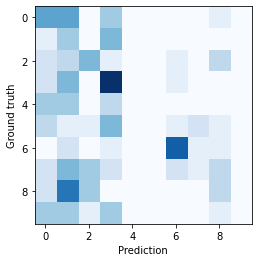

In [530]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Prediction');
plt.ylabel('Ground truth');

Analizzando i risultati si vede che l'accuracy è del 26% e dalla confusion matrix si nota una tendenza esagerata del classificatore ad ettichettare con i valori 0, 1 e 3. Si ha quindi una bassa precision.

### ZCR with energy and duration
In questa sezione alleniamo una SVM utilizzando la feature ZCR unita ad energy e duration.

In [531]:
def combo2(input):
    return np.concatenate((energy(input),duration(input),zcr(input)))

In [532]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo2, normalize=True)

In [533]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 2.932s


In [534]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 100
 gamma: 1.0


In [535]:
# SVM test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.41      0.50        17
           1       0.33      0.80      0.47        10
           2       0.50      0.53      0.52        15
           3       0.67      0.32      0.43        19
           4       0.33      0.36      0.35        11
           5       0.39      0.50      0.44        14
           6       0.83      0.71      0.77        14
           7       0.50      0.21      0.30        19
           8       0.42      0.59      0.49        17
           9       0.56      0.64      0.60        14

    accuracy                           0.49       150
   macro avg       0.52      0.51      0.49       150
weighted avg       0.53      0.49      0.48       150



Confusion matrix:


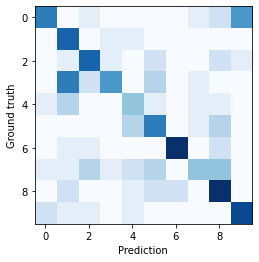

In [536]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Prediction');
plt.ylabel('Ground truth');

Unendo tutte e tre le feature normalizzate si ottengono dei risultati migliori: l'accuracy sale a circa il 50% e non ci sono tendenze esagerate nell'assegnare sempre le stesse etichette. Il 6 risulta essere la cifra meglio riconosciuta con una precision dell'83% e recall del 71% ed ha infatti il miglior F1-score. Visti gli esperimenti, lo ZCR risulta essere in definitiva una feature utile per il riconoscimento di audio. 